In [1]:
# run the header that sets up the environment

if "already_run" not in globals():
    globals()["already_run"] = True
    
    %run header.ipynb # defines load_packages, change_wordir, colourblind_palette, checkpoint, and other 
    load_packages()
    change_wordir()
colors, colours = colourblind_palette("own")

analysis = "steady_state_dynamics"

model = "cyclic_2021"
#model = "latest_dev"
#model = "new_PSI"

m = load_model(model)

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0

succesfully loaded cyclic_2021 :D


# generating data

In [2]:

def pfd_ss_scan(s: object, pfd_values: np.ndarray, y0_loop: dict, debug: bool =False) -> tuple:
    """
    Perform a steady-state scan by varying the parameter "pfd" across different values.

    Returns:
    tuple:
        - DataFrame of steady-state concentrations (rows: pfd values, columns: compound names).
        - DataFrame of steady-state fluxes (rows: pfd values, columns: reaction rates).
    """

    backup_y0 = y0_loop.copy()  # Backup the conditions to reset the system if needed

    fluxes = {}  # store steady-state fluxes for each pfd value
    concentrations = {}  # store steady-state concentrations for each pfd value
    failed_cases = []

    # Iterate over each pfd value with a progress bar
    for x in tqdm(pfd_values, total=len(pfd_values)):  

        s.initialise(y0_loop)  # Reset the system with the given initial conditions
        s.update_parameter("pfd", x)  # Update the parameter "pfd" to the current value
        
        try:
            t, y = s.simulate_to_steady_state()

            if y is None or len(y) == 0:  # Check for invalid output
                raise ValueError(f"Simulation returned empty result at pfd={x}")

            # Store the final steady-state concentrations
            concentrations[x] = s.get_full_results_array()[-1]

            # Store the final steady-state fluxes
            fluxes[x] = s.model.get_fluxes_array(y=y, t=t)[-1]

            # Update initial conditions for the next iteration
            y0_loop = s.get_new_y0()

        except Exception as e:
            logger.warning(f"Simulation failed at pfd={x}: {e}")
            failed_cases.append(x)

            # Store NaNs for failed cases
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = np.full(len(all_compounds), np.nan)
            fluxes[x] = np.full(len(rate_names), np.nan)

            # If debug mode is enabled, log additional details
            if debug:
                logger.debug(f"Failed pfd={x}. Initial conditions: {y0_loop}")

    # Log summary after execution
    logger.info(f"Simulation completed. {len(failed_cases)} cases failed: {failed_cases}")

    return (
        pd.DataFrame(concentrations, index=s.model.get_all_compounds()).T,  # Convert concentration results to DataFrame
        pd.DataFrame(fluxes, index=s.model.get_rate_names()).T  # Convert flux results to DataFrame
    )

NUM_SCANS = 100
LOW_LIGHT = 30
HIGH_LIGHT = 1750
PFD_VALUES = np.linspace(LOW_LIGHT, HIGH_LIGHT, NUM_SCANS)

y0 = {
    "PQ": 11.248282037382348,       "PC": 1.3639930534269078,       "Fd": 4.207984023619571,
    "ATP": 1.6085042256522668,      "NADPH": 0.45672250689837696,   "H": 0.002174958602661375,
    "LHC": 0.8079188314632375,      "Psbs": 0.9626375680773129,     "Vx": 0.9570474456930378,
    "PGA": 0.6109221284988471,      "BPGA": 0.0003235574325883373,  "GAP": 0.003190323205250446,
    "DHAP": 0.07018710225866034,    "FBP": 0.0015898274733035427,   "F6P": 0.0886998278393475,
    "G6P": 0.20400960399249862,     "G1P": 0.011832557030606641,    "SBP": 0.003215008299488195,
    "S7P": 0.02811069161049136,     "E4P": 0.003523560381569699,    "X5P": 0.006746131132013272,
    "R5P": 0.011299769265221232,    "RUBP": 0.030373422172205858,   "RU5P": 0.004519907641254276,
    "MDA": 2.2718326276618075e-06,
#    "ASC": 9.999997726884683,
    "H2O2": 1.3296482521160688e-06,
    "DHA": 1.2828228406972059e-09,
#    "GSH": 9.999999998752703,
    "GSSG": 6.236645512101874e-10,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
    "B0": 1,
    "B1": .25,
    "B2": 1
}

In [3]:
s = Simulator(m)
c, v = pfd_ss_scan(s, PFD_VALUES, y0, True)

100%|██████████| 100/100 [00:45<00:00,  2.22it/s]
2025-04-09 16:11:02,410 - INFO - Simulation completed. 0 cases failed: []


In [4]:
c = checkpoint("c", f"{model}/{analysis}")
v = checkpoint("v", f"{model}/{analysis}")

Saved: data/cyclic_2021/steady_state_dynamics\c.joblib
Saved: data/cyclic_2021/steady_state_dynamics\v.joblib


# plotting

### compounds

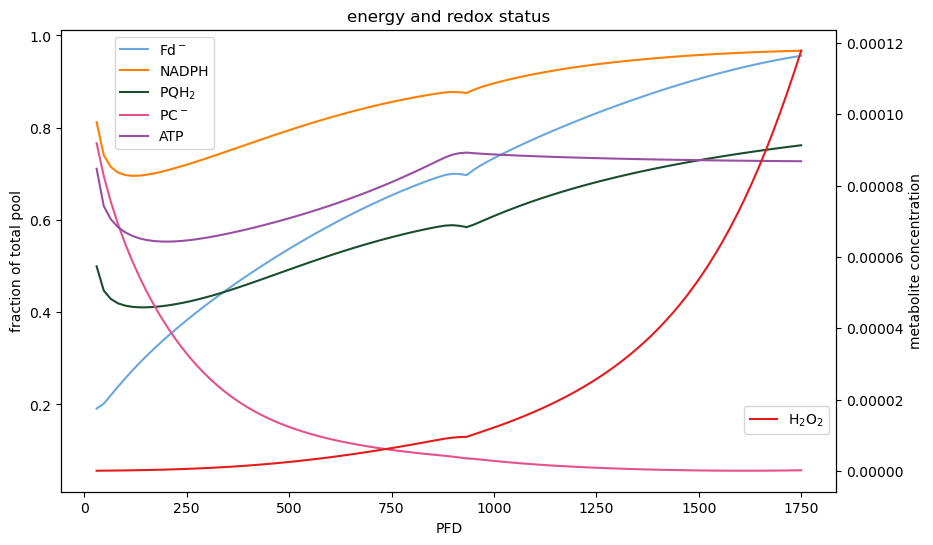

In [5]:
# ELECTRON CARRIERS

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(c["Fd_redoxstate"], label="Fd$^-$", color=colors[0])
ax1.plot(c["NADP_redoxstate"], label="NADPH", color=colors[1])
ax1.plot(c["PQ_redoxstate"], label="PQH$_2$", color=colors[2])
ax1.plot(c["PC_redoxstate"], label="PC$^-$", color=colors[3])
ax1.plot(c["ATP_norm"], label="ATP", color=colors[4])

ax2.plot(c["H2O2"], label="H$_2$O$_2$", color=colors[5])

# Set labels and legends
ax1.set(title="energy and redox status",
        xlabel="PFD",
        ylabel="fraction of total pool")
ax2.set_ylabel("metabolite concentration")

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0.06, 1))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))


In [6]:
save_fig(fig, model, analysis, f"energy_and_redox_status")

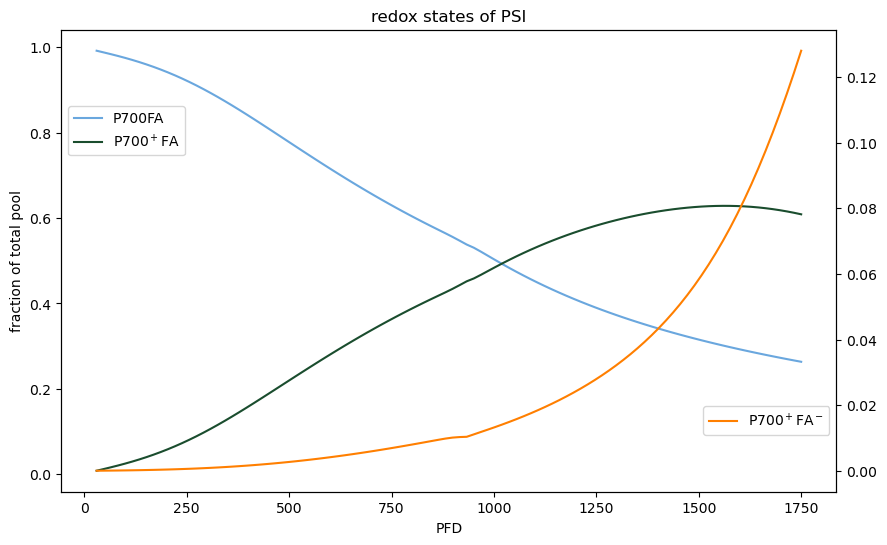

In [7]:
# PSI REDOX STATES

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(c["rel_P700FA"], label="P700FA", color=colors[0])
ax2.plot(c["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1])
ax1.plot(c["rel_P700+FA"], label="P700$^+$FA", color =colors[2])

if model != "cyclic_2021":
        ax2.plot(c["rel_P700FA-"], label = "P700FA$^{-}$", color=colors[3])

# Set labels and legends
ax1.set(title="redox states of PSI",
        xlabel="PFD",
        ylabel="fraction of total pool")

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.85))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))


In [8]:
save_fig(fig, model, analysis, f"PSI_redox_states")

### fluxes

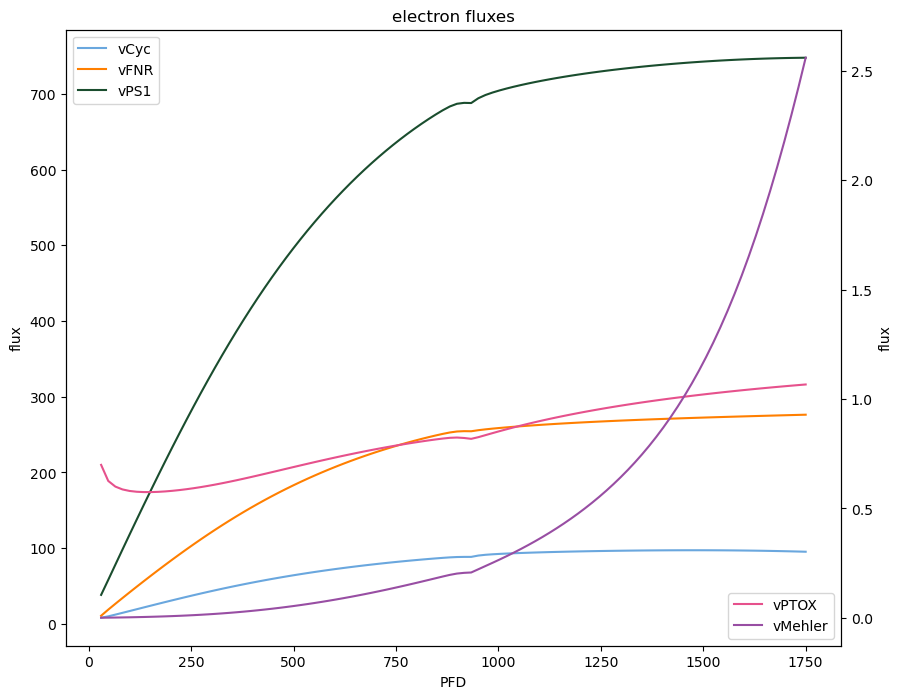

In [12]:
# ELECTRON FLUXES

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

ax1.plot(v["vCyc"], label="vCyc", color=colors[0])
ax1.plot(v["vFNR"], label="vFNR", color=colors[1])
ax1.plot(v["vPS1"], label="vPS1", color=colors[2])

ax2.plot(v["vPTOX"], label="vPTOX", color=colors[3])
#ax2.plot(v["v3_Mehler"], label="v3_Mehler", color=colors[4])
#ax2.plot(v["v4_Mehler"], label="v4_Mehler", color=colors[5])
ax2.plot(v["vMehler"], label="vMehler", color=colors[4])  # ! if model is old

ax1.set(title="electron fluxes",
        xlabel="PFD",
        ylabel="flux")
ax2.set_ylabel("flux")

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

fig.show()


In [13]:
save_fig(fig, model, analysis, f"electron_flows")

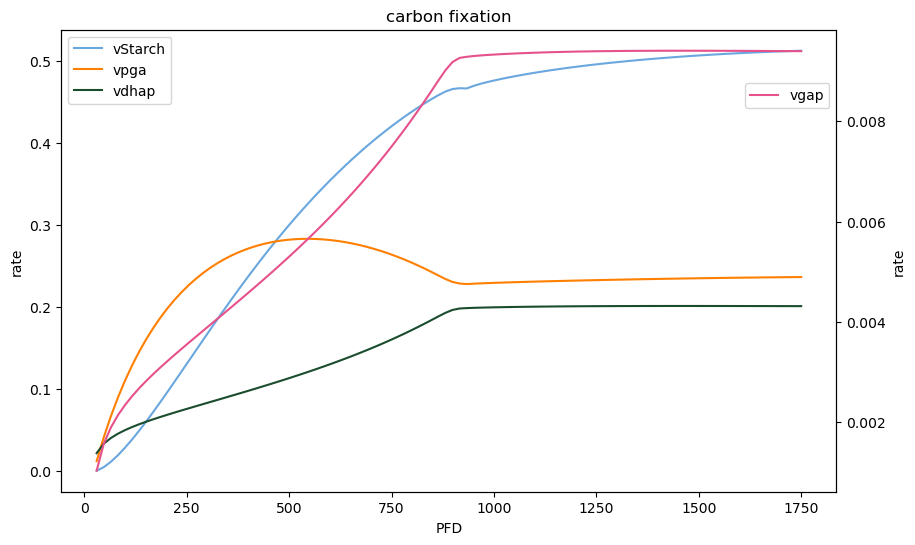

In [14]:
# CARBON FIXATION

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(v["vStarch"], label="vStarch", color=colors[0])
ax1.plot(v["vpga"], label="vpga", color=colors[1])
ax1.plot(v["vdhap"], label="vdhap", color=colors[2])

ax2.plot(v["vgap"], label="vgap", color=colors[3])

ax1.set(title="carbon fixation",
        xlabel="PFD",
        ylabel="rate")
ax2.set_ylabel("rate")

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

fig.show()

In [15]:
save_fig(fig, model, analysis, f"carbon_fixation_fluxes")

# Photosystem_rate (deprecated)

In [ ]:
# def plot_lines(ax, df, labels={"xlab": "no_label", "ylab": "no_label", "title": "no_title"}, **kwargs):
#     """Plot multiple lines from a DataFrame with non-overlapping end-point labels."""
    
#     # Set axis labels and title
#     ax.set_title(labels["title"])
#     ax.set_xlabel(labels["xlab"])
#     ax.set_ylabel(labels["ylab"])
    
#     texts = []  # Store text objects for later adjustment

#     # Plot each column separately with labels
#     for col_name in df.columns:
#         x_data = df.index
#         y_data = df[col_name]

#         # Avoid plotting entirely NaN columns
#         if np.isnan(y_data).all():
#             continue
        
#         # Plot line
#         ax.plot(x_data, y_data, label=col_name)
        
#         # Get last valid point
#         last_idx = np.where(~np.isnan(y_data))[0][-1]  
#         x_last, y_last = x_data[last_idx], y_data.iloc[last_idx]

#         # Create text label at last data point
#         texts.append(ax.text(x_last, y_last, col_name, fontsize=10, va='center', ha='left'))

#     ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

#     # Adjust text positions to avoid overlaps
#     adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

#     return ax

<Axes: title={'center': 'state fluxes of PSI'}, xlabel='PFD', ylabel='flux'>

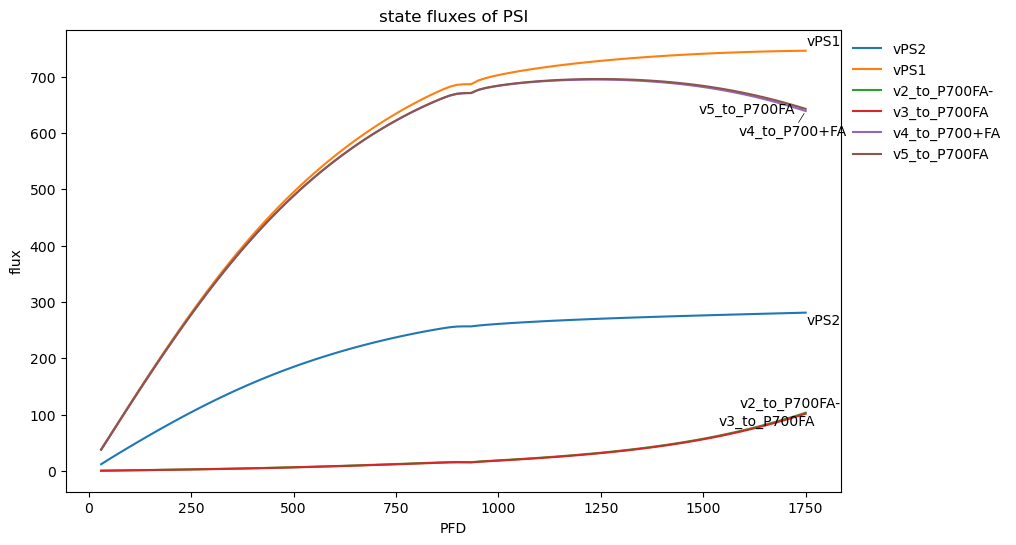

In [ ]:
# # PHOTOSYSTEM RATES

# df = v.loc[:,["vPS2",
#                 "vPS1",
#                 "v2_to_P700FA-",
#                 "v3_to_P700FA",
#                 "v4_to_P700+FA",
#                 "v5_to_P700FA"
# ]]
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# plot_lines(ax, df, labels={"xlab": "PFD", "ylab": "flux", "title": "state fluxes of PSI"})

# # v.loc[:,["vPS2",
#         # "vPS1",
#         # "vMehler",
#         # "v2_to_P700FA-",
#         # "v3_to_P700FA",
#         # "v4_to_P700+FA",
#         # "v5_to_P700FA"
#         # ]].plot(title="redox states of PSI",
#         #         xlabel="PFD",
#         #         ylabel="fraction of total pool",
#         #         #logy=True,
#         #         figsize=(10, 6))
# # plt.show()

In [ ]:
# folder = f"figures/{model}/steady_state_dynamics/"
# name = "PSI_state_fluxes"
# os.makedirs(folder, exist_ok=True)
# fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")
# plt.close(fig)

In [ ]:
# fig, ax = plt.subplots()

# # Simulated plot
# x = range(10)
# ax.plot(x, x, color="#377EB8", linestyle='-', label='Glucose Model A')
# ax.plot(x, [i*0.8 for i in x], color="#377EB8", linestyle='--', label='Glucose Model B')
# ax.plot(x, [i*1.2 for i in x], color="#4DAF4A", linestyle='-', label='Fructose Model A')

# # Custom legend handles
# metabolite_handles = [
#     Line2D([0], [0], color="#377EB8", lw=3, label='Glucose'),
#     Line2D([0], [0], color="#4DAF4A", lw=3, label='Fructose')
# ]

# model_handles = [
#     Line2D([0], [0], color='black', linestyle='-', lw=2, label='Model A'),
#     Line2D([0], [0], color='black', linestyle='--', lw=2, label='Model B')
# ]

# # First legend: Metabolites
# legend1 = ax.legend(handles=metabolite_handles, title="Metabolite", loc='upper left')
# ax.add_artist(legend1)  # Fix this one in place

# # Second legend: Models
# ax.legend(handles=model_handles, title="Model", loc='upper right')

# plt.show()